In [27]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import Audio, display

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Dataset Loading and Exploration

emotion
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


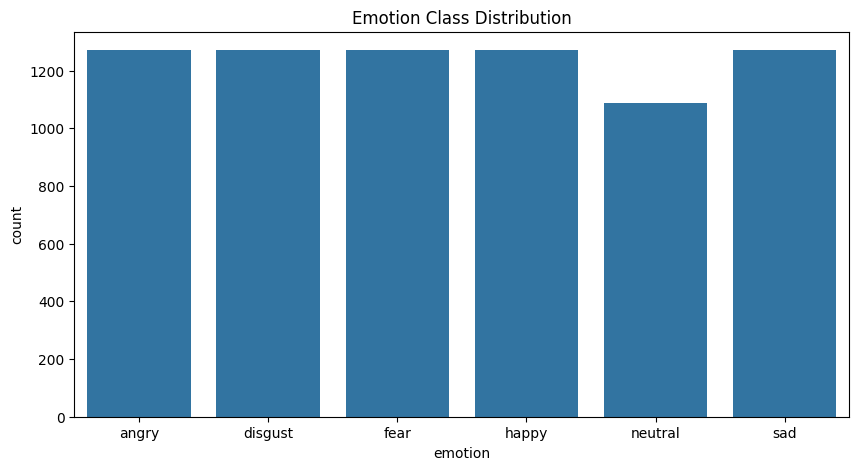

In [28]:
data_path = "C:/Users/3mara/Desktop/Speech-Emotion-Recognition/Crema"
audio_files = []
emotions = []
file_paths = []

# Walk through the directory structure
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            # Extract emotion from filename (CREMA-D naming convention)
            parts = file.split('_')
            if len(parts) >= 3:
                emotion_code = parts[2]
                if emotion_code == 'SAD':
                    emotions.append('sad')
                elif emotion_code == 'ANG':
                    emotions.append('angry')
                elif emotion_code == 'DIS':
                    emotions.append('disgust')
                elif emotion_code == 'FEA':
                    emotions.append('fear')
                elif emotion_code == 'HAP':
                    emotions.append('happy')
                elif emotion_code == 'NEU':
                    emotions.append('neutral')
                else:
                    emotions.append('unknown')
            audio_files.append(file)

# Create a DataFrame
df = pd.DataFrame({'file_path': file_paths, 'emotion': emotions})
df = df[df['emotion'] != 'unknown']  # Remove unknown emotions

# Check class distribution
print(df['emotion'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='emotion')
plt.title('Emotion Class Distribution')
plt.show()

## The waveform of the audio for each emotion


Playing sample for: angry



Playing sample for: disgust



Playing sample for: fear



Playing sample for: happy



Playing sample for: neutral



Playing sample for: sad


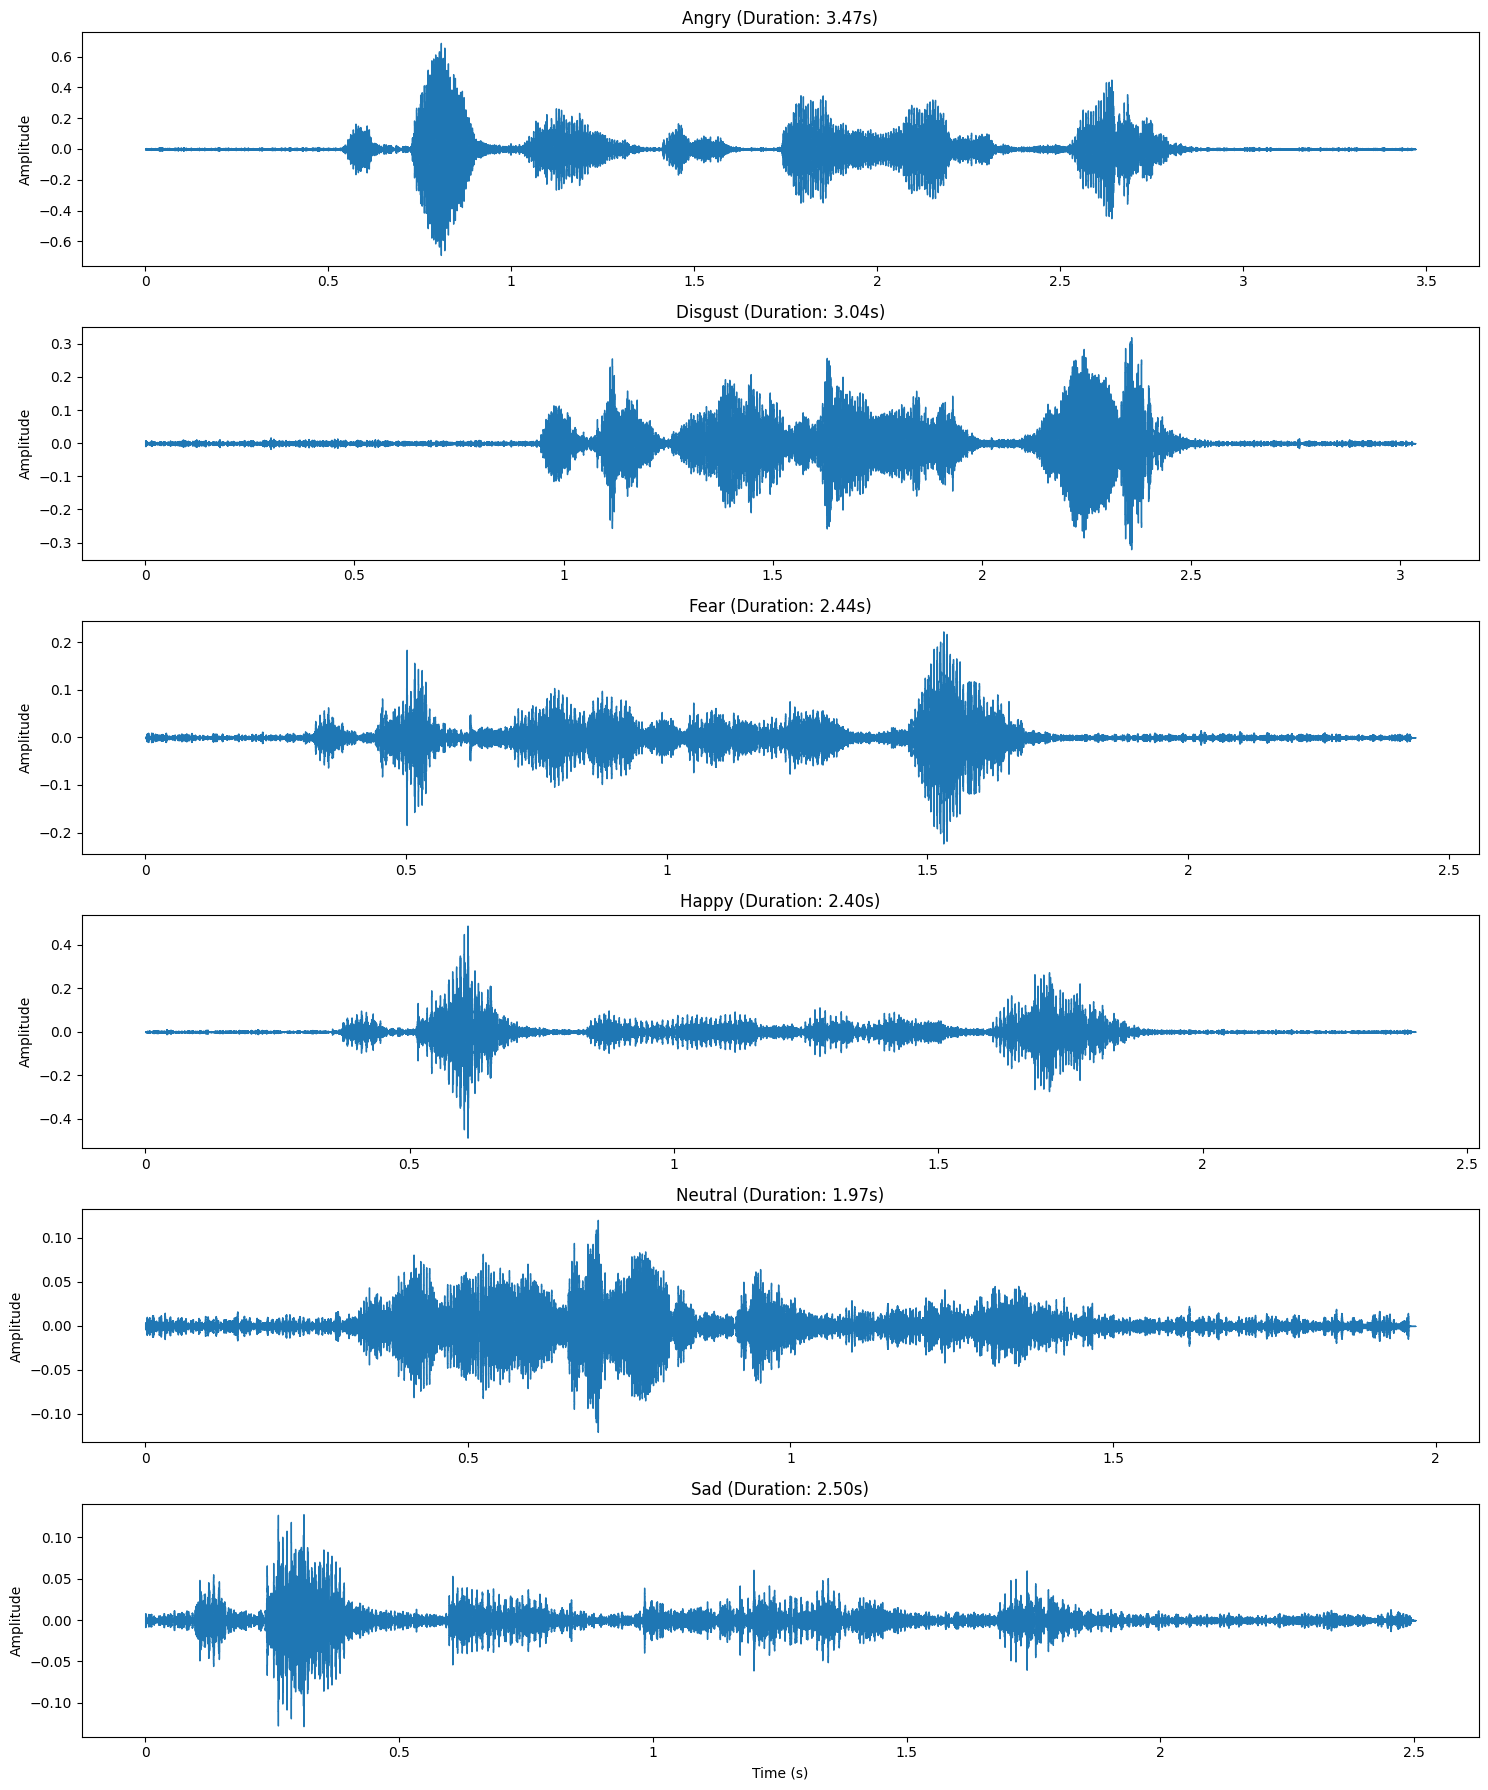

In [29]:
def plot_and_listen_audio_waveforms(df, num_examples=1):
    emotions = df['emotion'].unique()

    # Create figure for waveforms
    fig, axes = plt.subplots(nrows=len(emotions), ncols=num_examples,
                             figsize=(15, 3*len(emotions)))
    if num_examples == 1:
        axes = axes.reshape(-1, 1)

    for row_idx, emotion in enumerate(emotions):
        # Get random samples for this emotion
        emotion_samples = df[df['emotion'] == emotion].sample(num_examples, random_state=42)

        for col_idx in range(num_examples):
            ax = axes[row_idx, col_idx]
            file_path = emotion_samples.iloc[col_idx]['file_path']

            # Load audio
            y, sr = librosa.load(file_path, sr=None)

            # Plot waveform
            librosa.display.waveshow(y, sr=sr, ax=ax)
            ax.set(title=f'{emotion.capitalize()} (Duration: {len(y)/sr:.2f}s)',
                   xlabel='' if row_idx != len(emotions)-1 else 'Time (s)',
                   ylabel='Amplitude')

            # Display player
            print(f"\nPlaying sample for: {emotion}")
            display(Audio(y, rate=sr))

    plt.tight_layout()
    plt.show()

# Plot and listen to audio waveforms
plot_and_listen_audio_waveforms(df, num_examples=1)

## Statistics

In [30]:
# Calculate and plot statistics per emotion
stats = []
for emotion in df['emotion'].unique():
    sample = df[df['emotion'] == emotion].sample(100, random_state=42)
    durations = []
    max_amps = []
    for file_path in sample['file_path']:
        y, sr = librosa.load(file_path, sr=None)
        durations.append(len(y)/sr)
        max_amps.append(np.max(np.abs(y)))
    
    stats.append({
        'emotion': emotion,
        'avg_duration': np.mean(durations),
        'avg_max_amp': np.mean(max_amps)
    })

stats_df = pd.DataFrame(stats)

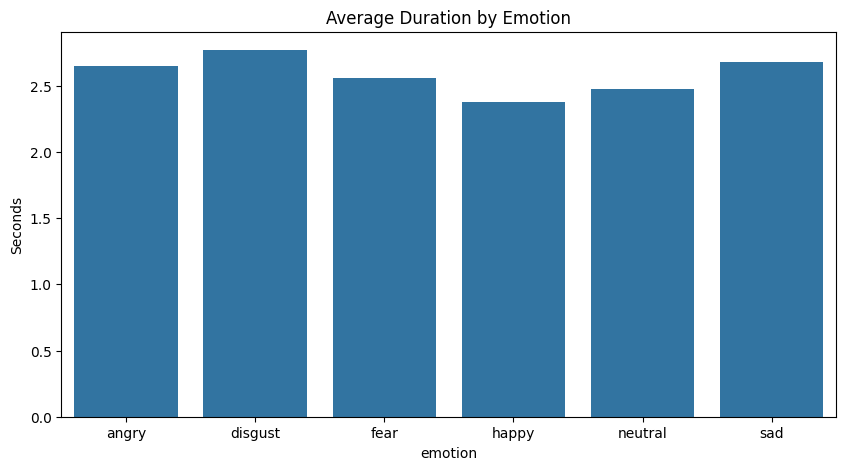

In [31]:
# Plot duration statistics
plt.figure(figsize=(10, 5))
sns.barplot(data=stats_df, x='emotion', y='avg_duration')
plt.title('Average Duration by Emotion')
plt.ylabel('Seconds')
plt.show()

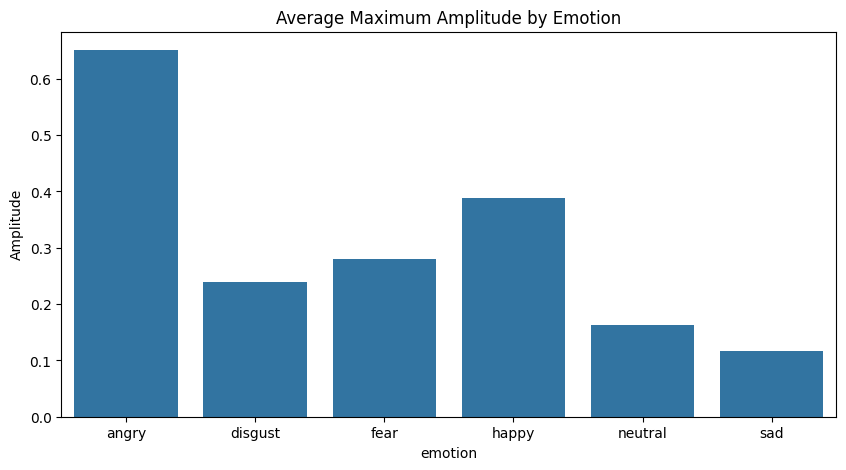

In [32]:
# Plot amplitude statistics
plt.figure(figsize=(10, 5))
sns.barplot(data=stats_df, x='emotion', y='avg_max_amp')
plt.title('Average Maximum Amplitude by Emotion')
plt.ylabel('Amplitude')
plt.show()

## Audio Processing and Feature Extraction
### Time Domain Features (ZCR and Energy)

In [45]:
def extract_time_features(file_path, frame_length=2048, hop_length=512):
    
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
    
    # Energy (Root Mean Square)
    rmse = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)


    
    # Stack features
    features = np.vstack([zcr, rmse])
    
    return features.T  # Transpose to get (time_steps, features)

# Example usage
sample_file = df.iloc[0]['file_path']
time_features = extract_time_features(sample_file)
print("Time features shape:", time_features.shape)

Time features shape: (72, 2)


### Frequency Domain Features (Mel Spectrogram)

Mel spectrogram shape: (128, 72)


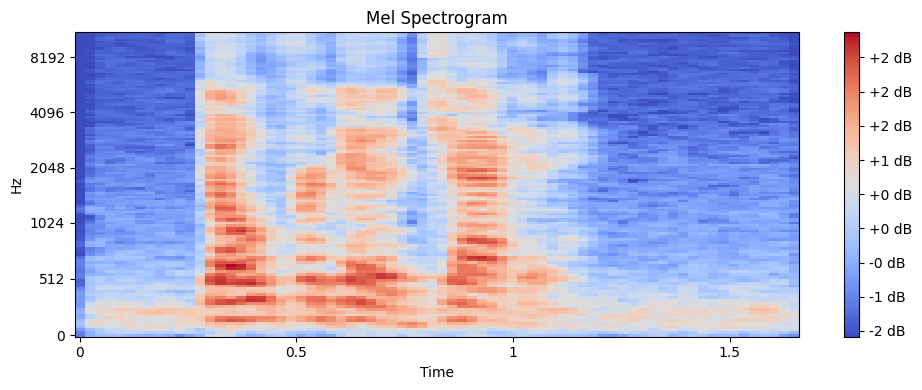

In [46]:
def extract_mel_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
   
    y, sr = librosa.load(file_path, sr=None)
    
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                             hop_length=hop_length, n_mels=n_mels)
    
    # Convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize the log-mel spectrogram to zero mean and unit variance
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    normalized_log_mel_spec = (log_mel_spec - mean) / (std + 1e-10)  # avoid division by zero
    
    return normalized_log_mel_spec

# Example usage
mel_features = extract_mel_spectrogram(sample_file)
print("Mel spectrogram shape:", mel_features.shape)

# Visualize a sample
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_features, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(0, 1, size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    if random:
        pitch_factor = np.random.uniform(-pitch_factor, pitch_factor)  
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


def extract_augmented_features(file_path, max_time_steps, n_mels):
    y, sr = librosa.load(file_path, sr=None)
    
    # Original
    features = []

    for y_aug in [y, noise(y, random=True), pitch(y, sr, random=True)]:
        # Time features
        zcr = librosa.feature.zero_crossing_rate(y_aug)
        rmse = librosa.feature.rms(y=y_aug)
        time_feat = np.vstack([zcr, rmse]).T
        if time_feat.shape[0] >= max_time_steps:
            time_feat = time_feat[:max_time_steps]
        else:
            pad = np.zeros((max_time_steps - time_feat.shape[0], 2))
            time_feat = np.vstack([time_feat, pad])
        
        # Mel features
        mel_spec = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_fft=2048, hop_length=512, n_mels=n_mels)
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-10)
        if log_mel.shape[1] >= max_time_steps:
            log_mel = log_mel[:, :max_time_steps]
        else:
            pad_width = ((0, 0), (0, max_time_steps - log_mel.shape[1]))
            log_mel = np.pad(log_mel, pad_width, mode='constant')
        
        features.append((time_feat, log_mel))
    
    return features  # List of (time, mel) tuples


## Data Preparation and Splitting

In [61]:
y = pd.get_dummies(df['emotion']).values

# First split into train+val and test sets (70%/30%)
# Split into train/test first
# Split into train (70%), test (30%)
df_train_val, df_test, y_train_val, y_test = train_test_split(
    df, y, test_size=0.3, stratify=y, random_state=42)

# Split train_val into train (95%) and val (5%)
df_train, df_val, y_train, y_val = train_test_split(
    df_train_val, y_train_val, test_size=0.05, stratify=y_train_val, random_state=42)


y_train_original = y_train.copy()

In [62]:
def extract_features(file_paths, labels):
    X_time = []
    X_mel = []
    for path in file_paths:
        time_feat = extract_time_features(path)
        mel_feat = extract_mel_spectrogram(path)
        
        # Padding/truncating
        if time_feat.shape[0] >= max_time_steps:
            time_feat = time_feat[:max_time_steps]
        else:
            time_feat = np.pad(time_feat, ((0, max_time_steps - time_feat.shape[0]), (0, 0)))
        
        if mel_feat.shape[1] >= max_time_steps:
            mel_feat = mel_feat[:, :max_time_steps]
        else:
            mel_feat = np.pad(mel_feat, ((0, 0), (0, max_time_steps - mel_feat.shape[1])))
        
        X_time.append(time_feat)
        X_mel.append(mel_feat[..., np.newaxis])
    
    return np.array(X_time), np.array(X_mel)


# Prepare features and labels
max_time_steps = 100  # Fixed number of time steps for time features
n_mels = 128
time_feature_dim = 2  # ZCR and Energy


# Before augmentation 
X_time_tune, X_mel_tune = extract_features(df_train['file_path'], y_train)

# Prepare empty lists (we will append instead of preallocate because of augmentation)
X_time_train = []
X_mel_train = []
y_train_aug = []

# Only augment training set (not validation or test)
for i, file_path in enumerate(df_train['file_path']):
    label_vec = y_train[i]
    augmented_feats = extract_augmented_features(file_path, max_time_steps, n_mels)
    
    for time_feat, mel_feat in augmented_feats:
        X_time_train.append(time_feat)
        X_mel_train.append(mel_feat[..., np.newaxis])
        y_train_aug.append(label_vec)

X_time_train = np.array(X_time_train)
X_mel_train = np.array(X_mel_train)
y_train = np.array(y_train_aug)



X_time_val, X_mel_val = extract_features(df_val['file_path'], y_val)
X_time_test, X_mel_test = extract_features(df_test['file_path'], y_test)

print("Time features shapes:")
print("Train:", X_time_train.shape, "Validation:", X_time_val.shape, "Test:", X_time_test.shape)
print("Mel features shapes:")
print("Train:", X_mel_train.shape, "Validation:", X_mel_val.shape, "Test:", X_mel_test.shape)

Time features shapes:
Train: (14844, 100, 2) Validation: (261, 100, 2) Test: (2233, 100, 2)
Mel features shapes:
Train: (14844, 128, 100, 1) Validation: (261, 128, 100, 1) Test: (2233, 128, 100, 1)


## Model Building
### 1D CNN for Time Domain Features

In [51]:
def build_1d_cnn(input_shape, num_classes, learning_rate):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(64, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(256, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                 metrics=['accuracy'])
    
    return model

Learning rate & Batch size tuning 

In [52]:
def tune_1d_cnn(X_train, y_train, X_val, y_val, input_shape, num_classes):
    learning_rates = [1e-2, 1e-3, 1e-4]
    batch_sizes = [16, 32, 64]
    best_val_acc = 0
    best_params = None

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\nTrying LR={lr}, Batch Size={bs}")
            model = build_1d_cnn(input_shape, num_classes, learning_rate=lr)
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                          metrics=['accuracy'])

            history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=10,  # Short for tuning
                                batch_size=bs,
                                verbose=0)

            val_acc = history.history['val_accuracy'][-1]
            print(f"Validation Accuracy: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, bs)

    print(f"\nBest Parameters: LR={best_params[0]}, Batch Size={best_params[1]}")
    return best_params


# Time CNN tuning
best_time_params = tune_1d_cnn(
    X_time_train, y_train, X_time_val, y_val,
    input_shape=(max_time_steps, time_feature_dim),
    num_classes=y.shape[1]
)




Trying LR=0.01, Batch Size=16
Validation Accuracy: 0.3908

Trying LR=0.01, Batch Size=32
Validation Accuracy: 0.4138

Trying LR=0.01, Batch Size=64
Validation Accuracy: 0.3716

Trying LR=0.001, Batch Size=16
Validation Accuracy: 0.4521

Trying LR=0.001, Batch Size=32
Validation Accuracy: 0.4215

Trying LR=0.001, Batch Size=64
Validation Accuracy: 0.4061

Trying LR=0.0001, Batch Size=16
Validation Accuracy: 0.4828

Trying LR=0.0001, Batch Size=32
Validation Accuracy: 0.4176

Trying LR=0.0001, Batch Size=64
Validation Accuracy: 0.4598

Best Parameters: LR=0.0001, Batch Size=16


In [53]:
# Build and train 1D CNN
time_cnn = build_1d_cnn((max_time_steps, time_feature_dim), y.shape[1], learning_rate=best_time_params[0])
time_cnn.summary()


history_time = time_cnn.fit(X_time_train, y_train,
                           validation_data=(X_time_val, y_val),
                           epochs=50, batch_size=best_time_params[1],
                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_99 (Conv1D)              │ (None, 96, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_100 (Conv1D)             │ (None, 44, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 44, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 18, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 18, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_33     │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,350 (942.77 KB)

 Trainable params: 240,454 (939.27 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3129 - loss: 1.7063 - val_accuracy: 0.4061 - val_loss: 1.5273
Epoch 2/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3832 - loss: 1.5650 - val_accuracy: 0.3946 - val_loss: 1.5081
Epoch 3/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4152 - loss: 1.5220 - val_accuracy: 0.4215 - val_loss: 1.4994
Epoch 4/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4271 - loss: 1.5032 - val_accuracy: 0.4330 - val_loss: 1.4952
Epoch 5/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4515 - loss: 1.4677 - val_accuracy: 0.4330 - val_loss: 1.4751
Epoch 6/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4710 - loss: 1.4427 - val_accuracy: 0.4483 - val_loss: 1.4710
Epoch 7/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4768 - loss: 1.4236 - val_accuracy: 0.4674 - val_loss: 1.4393
Epoch 8/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4919 - loss: 1.4044 - val_accuracy: 0

### 2D CNN for Mel Spectrogram Features

In [55]:
def build_2d_cnn(input_shape, num_classes, learning_rate):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                 metrics=['accuracy'])
    
    return model

Learning rate & Batch size tuning 

In [63]:
def tune_2d_cnn(X_train, y_train, X_val, y_val, input_shape, num_classes):
    learning_rates = [1e-2, 1e-3, 1e-4]
    batch_sizes = [16, 32, 64]
    best_val_acc = 0
    best_params = None

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\nTrying LR={lr}, Batch Size={bs}")
            model = build_2d_cnn(input_shape, num_classes, learning_rate=lr)
            
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                          metrics=['accuracy'])

            history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=10,  # Short for tuning
                                batch_size=bs,
                                verbose=0)

            val_acc = history.history['val_accuracy'][-1]
            print(f"Validation Accuracy: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, bs)

    print(f"\nBest Parameters: LR={best_params[0]}, Batch Size={best_params[1]}")
    return best_params


# Mel CNN tuning
best_mel_params = tune_2d_cnn(
    X_mel_tune, y_train_original, X_mel_val, y_val,
    input_shape=(n_mels, max_time_steps, 1),
    num_classes=y.shape[1]
)




Trying LR=0.01, Batch Size=16
Validation Accuracy: 0.4215

Trying LR=0.01, Batch Size=32
Validation Accuracy: 0.3831

Trying LR=0.01, Batch Size=64
Validation Accuracy: 0.2874

Trying LR=0.001, Batch Size=16
Validation Accuracy: 0.3908

Trying LR=0.001, Batch Size=32
Validation Accuracy: 0.4483

Trying LR=0.001, Batch Size=64
Validation Accuracy: 0.3333

Trying LR=0.0001, Batch Size=16
Validation Accuracy: 0.5249

Trying LR=0.0001, Batch Size=32
Validation Accuracy: 0.5057

Trying LR=0.0001, Batch Size=64
Validation Accuracy: 0.4866

Best Parameters: LR=0.0001, Batch Size=16


In [64]:
# Build and train 2D CNN
mel_cnn = build_2d_cnn((n_mels, max_time_steps, 1), y_train.shape[1], learning_rate=best_mel_params[0])
mel_cnn.summary()

history_mel = mel_cnn.fit(X_mel_train, y_train,
                         validation_data=(X_mel_val, y_val),
                         epochs=50, batch_size=best_mel_params[1],
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 126, 98, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 126, 98, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 63, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 61, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_142         │ (None, 61, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_143         │ (None, 28, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,854 (433.02 KB)

 Trainable params: 110,406 (431.27 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 105s 110ms/step - accuracy: 0.3245 - loss: 1.6597 - val_accuracy: 0.4138 - val_loss: 1.5129
Epoch 2/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.4240 - loss: 1.5206 - val_accuracy: 0.4061 - val_loss: 1.5222
Epoch 3/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.4661 - loss: 1.4552 - val_accuracy: 0.4559 - val_loss: 1.4577
Epoch 4/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.4809 - loss: 1.4284 - val_accuracy: 0.3985 - val_loss: 1.5312
Epoch 5/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 109ms/step - accuracy: 0.4978 - loss: 1.3980 - val_accuracy: 0.4789 - val_loss: 1.4205
Epoch 6/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.5165 - loss: 1.3724 - val_accuracy: 0.4521 - val_loss: 1.4311
Epoch 7/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.5294 - loss: 1.3465 - val_accuracy: 0.4713 - val_loss: 1.4284
Epoch 8/50
928/928 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.5487 -

## Model Evaluation

In [15]:
def evaluate_model(model, X_test, y_test, feature_type):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n{feature_type} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion matrix
    class_names = df['emotion'].unique()
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {feature_type} Features')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy, f1

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Time Domain Model Evaluation:
Accuracy: 0.5262
F1 Score: 0.5130


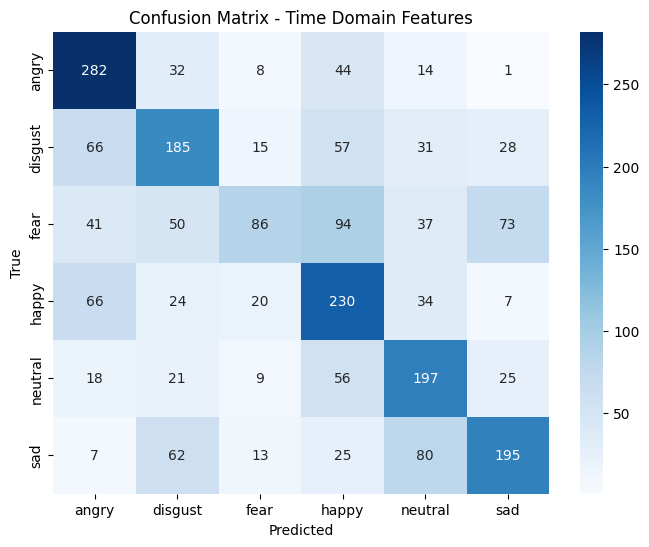

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step

Mel Spectrogram Model Evaluation:
Accuracy: 0.5683
F1 Score: 0.5713


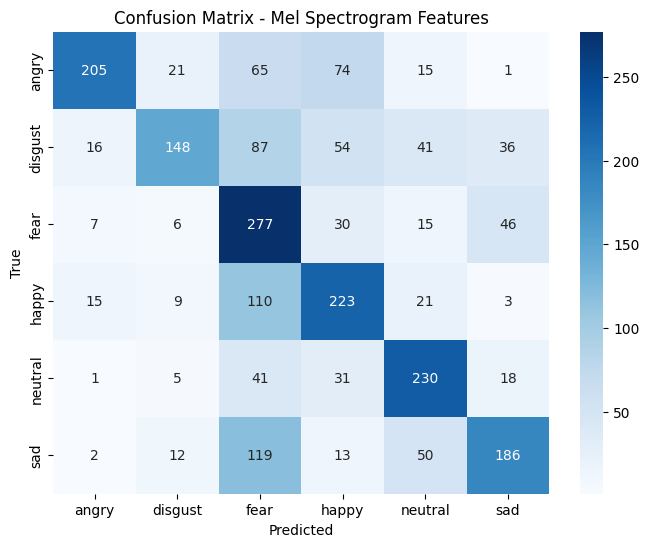


Model Comparison:
Time Domain CNN - Accuracy: 0.5262, F1: 0.5130
Mel Spectrogram CNN - Accuracy: 0.5683, F1: 0.5713


In [65]:
# Evaluate both models
time_accuracy, time_f1 = evaluate_model(time_cnn, X_time_test, y_test, "Time Domain")
mel_accuracy, mel_f1 = evaluate_model(mel_cnn, X_mel_test, y_test, "Mel Spectrogram")

# Compare models
print("\nModel Comparison:")
print(f"Time Domain CNN - Accuracy: {time_accuracy:.4f}, F1: {time_f1:.4f}")
print(f"Mel Spectrogram CNN - Accuracy: {mel_accuracy:.4f}, F1: {mel_f1:.4f}")